In [4]:
import xml.etree.ElementTree as ET
import urllib.request, urllib.parse, urllib.error
from tqdm import tqdm_notebook
from datetime import date
from collections import namedtuple
from collections import Counter
import re

In [27]:
Proposition = namedtuple('Proposition', ['data_votacao', 'cod', 'tipo', 'numero', 'ano_proposicao'])
Vote = namedtuple('Vote', ['data_votacao', 'cod', 'tipo', 'numero', 'ano_proposicao'])
Orientacao = namedtuple('Orientacao', ['data_votacao', 'cod_prop', 'cod_sessao', 'sigla', 'orientacao'])
def getPropositionsInYear(year):
    props = []
    url = 'http://www.camara.gov.br/SitCamaraWS/Proposicoes.asmx/ListarProposicoesVotadasEmPlenario?ano=' + str(year) + '&tipo='
    document = urllib.request.urlopen (url).read()
    root = ET.fromstring(document)
    for prop in root.findall('proposicao'):
        cod = prop.find('codProposicao').text
        nome = prop.find('nomeProposicao').text
        content = nome.split()
        tipo = content[0]
        content = content[1].split('/')
        numero = content[0]
        ano_proposicao = content[1]
        data_votacao = prop.find('dataVotacao').text
        h = cod + ano_proposicao
        props.append(Proposition(data_votacao, cod, tipo, numero, ano_proposicao))
    return props
def get_orientacoes(prop): 
    orientacoes = []
    objs_votacao = []
    url = 'http://www.camara.gov.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=' + prop.tipo + '&numero=' + prop.numero + '&ano=' + prop.ano_proposicao
    try:
        document = urllib.request.urlopen(url).read()
        root = ET.fromstring(document)
        for votacoes in root.findall('Votacoes'):
            for votacao in votacoes.findall('Votacao'):
                hora = votacao.get('Hora').strip()
                data = votacao.get('Data').strip()
                codSessao = votacao.get('codSessao').strip()
                objs_votacao.append(votacao)
                for orientacao in votacao.findall('orientacaoBancada'):
                    for bancada in orientacao.findall('bancada'):
                        sigla = bancada.get('Sigla').strip()
                        orientacao = bancada.get('orientacao').strip().upper()
                        orientacoes.append(Orientacao(data, prop.cod, codSessao, sigla, orientacao))
    except:
        pass
    return orientacoes,objs_votacao

In [6]:
props = []
for ano in tqdm_notebook(range(1991, date.today().year+1), position=1, desc='Carregando', ncols=700):
    props.extend(getPropositionsInYear(ano))

In [7]:
len(props), props[:5]

(3624,
 [Proposition(data_votacao='17/12/1991', cod='20976', tipo='PL', numero='4580', ano_proposicao='1990'),
  Proposition(data_votacao='07/11/1991', cod='167035', tipo='PDC', numero='63', ano_proposicao='1991'),
  Proposition(data_votacao='28/06/1991', cod='167073', tipo='PDC', numero='66', ano_proposicao='1991'),
  Proposition(data_votacao='19/09/1991', cod='167073', tipo='PDC', numero='66', ano_proposicao='1991'),
  Proposition(data_votacao='04/09/1991', cod='167304', tipo='PDC', numero='87', ano_proposicao='1991')])

In [28]:
ori,objs_votacao = get_orientacoes(props[1500])

In [59]:
objs_votacao[1].find('votos')[0].keys()

['Nome', 'ideCadastro', 'Partido', 'UF', 'Voto']

In [52]:
xmlstr = ET.tostring(objs_votacao[1], encoding='utf8', method='xml')
print(xmlstr)

b'<?xml version=\'1.0\' encoding=\'utf8\'?>\n<Votacao Data="31/10/2007" Hora="18:44" ObjVotacao="SUBEMENDA SUBSTITUTIVA" Resumo="Aprovada a Subemenda Substitutiva. Sim: 291; N\xc3\xa3o: 111; Absten\xc3\xa7\xc3\xa3o:1; Total: 403." codSessao="3300">\n      <orientacaoBancada>\n        <bancada Sigla="PmdbPscPtc" orientacao="Sim            " />\n        <bancada Sigla="PT" orientacao="Sim            " />\n        <bancada Sigla="PsbPdtPCdoBPmnPhsPrb" orientacao="Sim            " />\n        <bancada Sigla="DEM" orientacao="N\xc3\xa3o            " />\n        <bancada Sigla="PSDB" orientacao="N\xc3\xa3o            " />\n        <bancada Sigla="PR" orientacao="Sim            " />\n        <bancada Sigla="PP" orientacao="Sim            " />\n        <bancada Sigla="PTB" orientacao="Sim            " />\n        <bancada Sigla="PV" orientacao="Sim            " />\n        <bancada Sigla="PPS" orientacao="N\xc3\xa3o            " />\n        <bancada Sigla="PSOL" orientacao="N\xc3\xa3o         

In [6]:
reversed_props = list(reversed(props))
orientacoes = []
for prop in tqdm_notebook(reversed_props, position=1, desc='Carregando', ncols=700):
    orientacoes.extend(get_orientacoes(prop))

In [15]:
print(orientacoes[0])
with open('data/orientacoes.csv', 'w') as fout:
    for orientacao in orientacoes:
        fout.write('%s\t%s\t%s\t%s\t%s\n' % (orientacao.data_votacao,
                                             orientacao.cod_prop,
                                             orientacao.cod_sessao,
                                             orientacao.sigla,
                                             orientacao.orientacao)) 

Orientacao(data_votacao='26/3/2019', cod_prop='2194540', cod_sessao='16760', sigla='PslPpPsd...', orientacao='LIBERADO')


In [8]:
def filter_bancada(orientacoes):
    orientacoes_filtered = []
    for orientacao in tqdm_notebook(orientacoes, desc="Initial Filter"):
        if '/' in orientacao.sigla:
            for sigla in orientacao.sigla.split('/'):
                orientacoes_filtered.append(
                    Orientacao(orientacao.data_votacao,
                               orientacao.cod_prop,
                               orientacao.cod_sessao,
                               sigla,
                               orientacao.orientacao))
        elif 'Repr.' in orientacao.sigla:
            orientacoes_filtered.append(
                Orientacao(orientacao.data_votacao,
                           orientacao.cod_prop,
                           orientacao.cod_sessao,
                           orientacao.sigla.replace('Repr.',''),
                           orientacao.orientacao)
            )
        else:
            orientacoes_filtered.append(orientacao)
    orientacoes_filtered2 = []
    parties = ['Pmdb', 'Psd', 'Pt', 'Dem', 'Pen', 'Pan', 'Pv', 'Sd', 'Pros', 'Pps', 'Psdc',
               'Psdb', 'PTdoB', 'Ptb', 'Psl', 'Ptc', 'Ptn', 'Pp', 'Psb', 'Pdt',
               'Pcdob', 'Psc', 'Pode', 'Podemos', 'PCdoB', 'Avante', 'Phs', 'PtdoB', 'Ptdob',
               'Prb', 'Prtb', 'Prp', 'Pr', 'Pmn']
    for orientacao in tqdm_notebook(orientacoes_filtered, desc="Split bancada"):
        for party in sorted(parties, key=lambda x: len(x), reverse=True):
            if party in orientacao.sigla:
                orientacoes_filtered2.append(
                    Orientacao(orientacao.data_votacao,
                               orientacao.cod_prop,
                               orientacao.cod_sessao,
                               party.upper(),
                               orientacao.orientacao))
                orientacao = Orientacao(orientacao.data_votacao,
                       orientacao.cod_prop,
                       orientacao.cod_sessao,
                       orientacao.sigla.replace(party,'_'),
                       orientacao.orientacao)
        orientacoes_filtered2.append(orientacao)
    orientacoes_filtered = orientacoes_filtered2.copy()
    orientacoes_filtered2 = []
    for orientacao in tqdm_notebook(list(orientacoes_filtered), desc="Apply aliases"):
        if "_" in orientacao.sigla:
            continue
        elif 'Minoria' == orientacao.sigla or 'Maioria' == orientacao.sigla:
            orientacoes_filtered2.append(
                Orientacao(orientacao.data_votacao,
                           orientacao.cod_prop,
                           orientacao.cod_sessao,
                           orientacao.sigla.upper(),
                           orientacao.orientacao)
            )
        elif 'MDB' == orientacao.sigla:
            orientacoes_filtered2.append(
                Orientacao(orientacao.data_votacao,
                           orientacao.cod_prop,
                           orientacao.cod_sessao,
                           'PMDB',
                           orientacao.orientacao)
            )
        elif 'SDD' == orientacao.sigla or 'Solidaried' == orientacao.sigla :
            orientacoes_filtered2.append(
                Orientacao(orientacao.data_votacao,
                           orientacao.cod_prop,
                           orientacao.cod_sessao,
                           'SD',
                           orientacao.orientacao)
            )
        elif 'PODE' == orientacao.sigla:
            orientacoes_filtered2.append(
                Orientacao(orientacao.data_votacao,
                           orientacao.cod_prop,
                           orientacao.cod_sessao,
                           'PODEMOS',
                           orientacao.orientacao)
            )
        else:
            orientacoes_filtered2.append(orientacao)
    return orientacoes_filtered2

In [9]:
bancadas = set([orientacao.sigla for orientacao in orientacoes])
sorted(list(bancadas), key=lambda x: len(x), reverse=True)

['PmdbPpDemPsbPdtPodePcdobPscPhsAvantePen',
 'PrbPtnPmnPrpPsdcPrtbPtcPslPtdoB',
 'PmdbPpDemPodePscPhsAvantePen',
 'PrbPtnPmnPrpPsdcPtcPslPtdoB',
 'PsdbPrPrbPtbSdPpsProsPslPrp',
 'PrPrbPtdobPrtbPrpPhsPtcPsl',
 'PrPtdobPrpPhsPtcPslPrtb',
 'PrPtdobPrtbPrpPhsPtcPsl',
 'PmdbPpPtbDemSdPscPhsPen',
 'PsbPdtPcdobPmnPanPhsPrb',
 'PmdbPpPtbDemPscPhsPen',
 'PsbPdtPcdobPmnPhsPrb',
 'PsbPdtPcdobPmnPanPhs',
 'PrbPtnPmnPrpPsdcPrtb',
 'PrPtdobPrpPhsPslPrtb',
 'PsbPdtPCdoBPmnPhsPrb',
 'PrbPtnPmnPtcPtdoBPsl',
 'PtPsdPrPdtProsPcdob',
 'PrPtdobPrpPhsPtcPsl',
 'PL/PST/PSL/PMN/PSD',
 'PmdbPtbPscPTdoB...',
 'PpPodePscAvantePen',
 'PmdbPpPtbPscPhsPen',
 'PmdbPtPpPrPtbPsc..',
 'PsbPdtPcdobPmnPan',
 'PsbPdtPCdoBPmnPrb',
 'PrbPtnPmnPtcPtdoB',
 'PrbPtnPtcPtdoBPsl',
 'Apoio ao Governo',
 'PsdbPsdPrPrb...',
 'PpPodeAvantePen',
 'PmdbPpPtbDem...',
 'PsbPCdoBPmnPrb',
 'PdtPodePros...',
 'PrbPtnPtdobPsl',
 'PrPtdobPrpPhs',
 'PmdbPtbPscPtc',
 'PtbProsPslPrp',
 'PmdbPsdbPp...',
 'PtbSdPros...',
 'PdtSdPode...',
 'PMDB/PS

In [10]:
orientacoes_filtered = filter_bancada(orientacoes)

In [12]:
bancadas = Counter([orientacao.sigla for orientacao in orientacoes_filtered])
sorted(bancadas.items(), key=lambda x: x[1], reverse=True)

[('PT', 26929),
 ('PDT', 26867),
 ('PSB', 26832),
 ('PPS', 26689),
 ('PSDB', 26444),
 ('PCDOB', 26432),
 ('PTB', 26319),
 ('PMDB', 26302),
 ('PV', 22509),
 ('PSL', 20749),
 ('GOV.', 20687),
 ('PP', 17584),
 ('PSOL', 14893),
 ('PSC', 14880),
 ('PHS', 14276),
 ('PRB', 14194),
 ('PR', 14075),
 ('DEM', 13866),
 ('MINORIA', 13111),
 ('PFL', 12537),
 ('PL', 12142),
 ('PSD', 10808),
 ('PTN', 10808),
 ('PPB', 9336),
 ('PST', 8870),
 ('SD', 8682),
 ('PTC', 8455),
 ('PMN', 8451),
 ('PTDOB', 8044),
 ('PROS', 8020),
 ('PEN', 7615),
 ('PRP', 6352),
 ('REDE', 4966),
 ('PRTB', 4007),
 ('PRONA', 3132),
 ('PSDC', 2815),
 ('PMB', 2713),
 ('PODEMOS', 2587),
 ('MAIORIA', 1755),
 ('AVANTE', 1649),
 ('Oposição', 1055),
 ('Patriota', 852),
 ('NOVO', 612),
 ('PAN', 266),
 ('PSTU', 123),
 ('PPL', 116),
 ('PMR', 103),
 ('CIDADANIA', 90),
 ('Apoio ao Governo', 1)]

In [13]:
len(orientacoes_filtered)

540600

In [14]:
with open('data/orientacoes-filtered.csv', 'w') as fout:
    for orientacao in orientacoes_filtered:
        fout.write('%s\t%s\t%s\t%s\t%s\n' % (orientacao.data_votacao,
                                             orientacao.cod_prop,
                                             orientacao.cod_sessao,
                                             orientacao.sigla,
                                             orientacao.orientacao)) 

In [260]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [485]:
df = pd.DataFrame( [ [ ori.data_votacao, ori.cod_prop, ori.sigla, ori.orientacao  ] for ori in orientacoes_filtered ],
                  columns=['data_votacao', 'cod_prop', 'sigla', 'orientacao'] )
parties = list(set(df['sigla']))
le = LabelEncoder()
df['orientacao'] = le.fit_transform(df['orientacao'])
#df['data_votacao'] = df['data_votacao'].apply( lambda x: x.split('/')[-1] )
df = df.pivot_table(index=['data_votacao','cod_prop'], columns=['sigla'], values=['orientacao'], aggfunc='first' )

In [486]:
df.head()

orientacao                                              \
sigla                     AVANTE Apoio ao Governo CIDADANIA DEM GOV. MAIORIA   
data_votacao cod_prop                                                          
1998         164816          NaN              NaN       NaN NaN  4.0     NaN   
             169284          NaN              NaN       NaN NaN  4.0     NaN   
             216971          NaN              NaN       NaN NaN  4.0     NaN   
             218521          NaN              NaN       NaN NaN  4.0     NaN   
             224196          NaN              NaN       NaN NaN  4.0     NaN   

                                                ...                           \
sigla                 MINORIA NOVO Oposição PAN ... PSTU   PT  PTB PTC PTDOB   
data_votacao cod_prop                           ...                            
1998         164816       NaN  NaN      NaN NaN ...  NaN  2.0  4.0 NaN   NaN   
             169284       NaN  NaN      NaN NaN ...  2.0  2.0  4.0 NaN   NaN   
             216971       NaN  NaN      NaN NaN ...  NaN  4.0  4.0 NaN   NaN   
             218521       NaN  NaN      NaN NaN ...  NaN  2.0  4.0 NaN   NaN   
             224196       NaN  NaN      NaN NaN ...  4.0  4.0  4.0 NaN   NaN   

                                                  
sigla                 PTN   PV Patriota REDE  SD  
data_votacao cod_prop                             
1998         164816   NaN  NaN      NaN  NaN NaN  
             169284   NaN  NaN      NaN  NaN NaN  
             216971   NaN  NaN      NaN  NaN NaN  
             218521   NaN  NaN      NaN  NaN NaN  
             224196   NaN  4.0      NaN  NaN NaN  

[5 rows x 49 columns]

In [487]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer

X = df['orientacao'].as_matrix().T
imp = Imputer(axis=1)
X = imp.fit_transform(X)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

/home/mangaravite/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [488]:
colors = ['gray', 'navy', 'turquoise', 'darkorange', 'red']
parties.index('PT'), parties.index('PSDB'), parties.index('PMDB'), parties.index('PSL') 

def def_col(i, parties):
    if i == parties.index('PT'):
        return 'red'
    if i == parties.index('PSOL'):
        return 'darkred'
    if i == parties.index('PSDB'):
        return 'turquoise'
    if i == parties.index('PMDB'):
        return 'green'
    if i == parties.index('PSL'):
        return 'blue'
    return 'gray'

all_colors = [ def_col(i, parties) for i,col in enumerate(X_r) ]


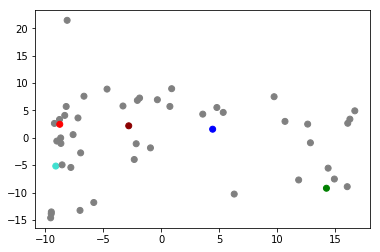

In [489]:
plt.scatter(X_r.T[0], X_r.T[1], color=all_colors)

In [505]:
df = pd.DataFrame( [ [ ori.data_votacao, ori.cod_prop, ori.sigla, ori.orientacao  ] for ori in orientacoes_filtered ],
                  columns=['data_votacao', 'cod_prop', 'sigla', 'orientacao'] )
parties = list(set(df['sigla']))
le = LabelEncoder()
df['orientacao'] = le.fit_transform(df['orientacao'])
df['data_votacao'] = df['data_votacao'].apply( lambda x: x.split('/')[-1] )
df = df.pivot_table(index=['cod_prop'], columns=['sigla','data_votacao'], values=['orientacao'], aggfunc='first' )
df.head()

orientacao                                                      \
sigla            AVANTE           Apoio ao Governo CIDADANIA  DEM             
data_votacao       2017 2018 2019             2013      2019 2007 2008 2009   
cod_prop                                                                      
100739              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
101666              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
102569              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
102704              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
104342              NaN  NaN  NaN              NaN       NaN  4.0  NaN  NaN   

                       ...                                                     
sigla                  ...  REDE             SD                                
data_votacao 2010 2011 ...  2017 2018 2019 2013 2014 2015 2016 2017 2018 2019  
cod_prop               ...                                                     
100739        NaN  NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
101666        2.0  NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
102569        NaN  NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
102704        NaN  NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
104342        NaN  NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 514 columns]

In [545]:
df['orientacao'].head().T.head()

cod_prop                       100739  101666  102569  102704  104342
sigla            data_votacao                                        
AVANTE           2017             NaN     NaN     NaN     NaN     NaN
                 2018             NaN     NaN     NaN     NaN     NaN
                 2019             NaN     NaN     NaN     NaN     NaN
Apoio ao Governo 2013             NaN     NaN     NaN     NaN     NaN
CIDADANIA        2019             NaN     NaN     NaN     NaN     NaN

In [546]:
df

orientacao                                                      \
sigla            AVANTE           Apoio ao Governo CIDADANIA  DEM             
data_votacao       2017 2018 2019             2013      2019 2007 2008 2009   
cod_prop                                                                      
100739              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
101666              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
102569              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
102704              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
104342              NaN  NaN  NaN              NaN       NaN  4.0  NaN  NaN   
104464              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
104885              NaN  NaN  NaN              NaN       NaN  NaN  NaN  4.0   
104934              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
1049380             NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
1050558             NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
1050643             NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
1050788             NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
105445              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
105490              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
105503              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
105504              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
105506              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
105507              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
106071              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
1063052             NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
106616              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
107630              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
109150              NaN  2.0  NaN              NaN       NaN  NaN  NaN  NaN   
109175              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
111346              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
112201              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
112202              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
112203              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
112893              NaN  NaN  NaN              NaN       NaN  NaN  NaN  4.0   
113716              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
...                 ...  ...  ...              ...       ...  ...  ...  ...   
622072              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
622360              NaN  4.0  NaN              NaN       NaN  NaN  NaN  NaN   
622854              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
623330              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
623649              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
65213               NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
66837               NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
69840               NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
744763              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
786713              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
796341              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
808898              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
818166              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
819408              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
858585              NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN   
860923              NaN  NaN  NaN              NaN       NaN  N

In [557]:
for year, group_year in df.T.groupby('data_votacao'):
    
    group_year = group_year.fillna(value=0)
    group_year = group_year.loc[:, (group_year.sum(axis=0) != 0.)]
    X = group_year.as_matrix()
    imp = Imputer(axis=1)
    X = imp.fit_transform(X)

    pca = PCA(n_components=8 )
    X_r = pca.fit(X).transform(X)
    
    print(group_year)
    

/home/mangaravite/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/mangaravite/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/mangaravite/.local/lib/python3.6/site-packages/ipykernel_launcher.

cod_prop                       164816  169284  216971  218521  224196  25003  \
           sigla data_votacao                                                  
orientacao GOV.  1998             4.0     4.0     4.0     4.0     4.0    4.0   
           PCDOB 1998             2.0     2.0     4.0     2.0     4.0    4.0   
           PDT   1998             2.0     2.0     4.0     2.0     4.0    4.0   
           PFL   1998             4.0     4.0     4.0     4.0     4.0    4.0   
           PL    1998             1.0     1.0     0.0     0.0     4.0    4.0   
           PMDB  1998             4.0     4.0     4.0     4.0     4.0    4.0   
           PMN   1998             0.0     0.0     0.0     0.0     4.0    0.0   
           PPB   1998             4.0     4.0     4.0     4.0     4.0    4.0   
           PPS   1998             2.0     2.0     2.0     2.0     4.0    4.0   
           PRONA 1998             4.0     4.0     4.0     4.0     4.0    4.0   
           PSB   1998             2.0   

cod_prop                         19319  302638  304008  325847  43617  44196  \
           sigla   data_votacao                                                
orientacao DEM     2014            3.0     4.0     4.0     2.0    4.0    4.0   
           GOV.    2014            2.0     2.0     2.0     2.0    2.0    0.0   
           MINORIA 2014            3.0     4.0     0.0     2.0    4.0    0.0   
           PCDOB   2014            2.0     1.0     2.0     2.0    4.0    4.0   
           PDT     2014            3.0     4.0     4.0     2.0    4.0    4.0   
           PEN     2014            0.0     0.0     0.0     0.0    0.0    0.0   
           PMDB    2014            3.0     2.0     4.0     2.0    4.0    4.0   
           PMN     2014            2.0     2.0     4.0     2.0    4.0    4.0   
           PP      2014            3.0     2.0     1.0     2.0    4.0    4.0   
           PPS     2014            3.0     4.0     4.0     2.0    4.0    4.0   
           PR      2014            3.0  

/home/mangaravite/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/mangaravite/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/mangaravite/.local/lib/python3.6/site-packages/ipykernel_launcher.

In [544]:
group_sigla

Empty DataFrame
Columns: []
Index: [(orientacao, AVANTE, 2019), (orientacao, CIDADANIA, 2019), (orientacao, DEM, 2019), (orientacao, GOV., 2019), (orientacao, MAIORIA, 2019), (orientacao, MINORIA, 2019), (orientacao, NOVO, 2019), (orientacao, Oposição, 2019), (orientacao, PCDOB, 2019), (orientacao, PDT, 2019), (orientacao, PHS, 2019), (orientacao, PMN, 2019), (orientacao, PODEMOS, 2019), (orientacao, PP, 2019), (orientacao, PPL, 2019), (orientacao, PPS, 2019), (orientacao, PR, 2019), (orientacao, PRB, 2019), (orientacao, PROS, 2019), (orientacao, PRP, 2019), (orientacao, PSB, 2019), (orientacao, PSC, 2019), (orientacao, PSD, 2019), (orientacao, PSDB, 2019), (orientacao, PSL, 2019), (orientacao, PSOL, 2019), (orientacao, PT, 2019), (orientacao, PTB, 2019), (orientacao, PV, 2019), (orientacao, Patriota, 2019), (orientacao, REDE, 2019), (orientacao, SD, 2019)]

In [475]:
X = df['orientacao'].fillna(value=-1).as_matrix().T

pca = PCA(n_components = 50, svd_solver = 'full')
X_r_50 = pca.fit(X).transform(X)

pca = PCA(n_components=2)
X_r_2 = pca.fit(X_r_50).transform(X_r_50)

/home/mangaravite/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [492]:
df['orientacao']

sigla        AVANTE           Apoio ao Governo CIDADANIA  DEM                 \
data_votacao   2017 2018 2019             2013      2019 2007 2008 2009 2010   
cod_prop                                                                       
100739          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
101666          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  2.0   
102569          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
102704          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
104342          NaN  NaN  NaN              NaN       NaN  4.0  NaN  NaN  NaN   
104464          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
104885          NaN  NaN  NaN              NaN       NaN  NaN  NaN  4.0  NaN   
104934          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
1049380         NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
1050558         NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
1050643         NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
1050788         NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
105445          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
105490          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
105503          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
105504          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
105506          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
105507          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
106071          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
1063052         NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
106616          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
107630          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
109150          NaN  2.0  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
109175          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
111346          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
112201          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
112202          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
112203          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
112893          NaN  NaN  NaN              NaN       NaN  NaN  NaN  4.0  NaN   
113716          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
...             ...  ...  ...              ...       ...  ...  ...  ...  ...   
622072          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
622360          NaN  4.0  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
622854          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
623330          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
623649          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
65213           NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
66837           NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
69840           NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
744763          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
786713          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
796341          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
808898          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
818166          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
819408          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
858585          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   
860923          NaN  NaN  NaN              NaN       NaN  NaN  NaN  NaN  NaN   


In [470]:
def def_col_df(party):
    if party == 'PT':
        return 'red'
    if party == 'PSOL':
        return 'darkred'
    if party == 'PSDB':
        return 'turquoise'
    if party == 'PMDB':
        return 'green'
    if party == 'PSL':
        return 'blue'
    return 'gray'
import numpy as np

In [471]:
df_X_r_2 = pd.DataFrame(X_r_2)
parties_df, year_df = list(zip(*df['orientacao'].T.index))
df_X_r_2['parties'] = list(parties_df)
df_X_r_2['year'] = list(year_df)

In [472]:
from collections import Counter
sorted(Counter(df_X_r_2['parties']).items(), key=lambda x: x[1],  reverse=True)

[('GOV.', 22),
 ('PCDOB', 22),
 ('PDT', 22),
 ('PPS', 22),
 ('PSB', 22),
 ('PSDB', 22),
 ('PT', 22),
 ('PTB', 22),
 ('PMDB', 21),
 ('PV', 21),
 ('PP', 17),
 ('PSC', 17),
 ('MINORIA', 16),
 ('PHS', 16),
 ('PSL', 15),
 ('PSOL', 15),
 ('PMN', 14),
 ('DEM', 13),
 ('PR', 13),
 ('PRB', 13),
 ('PSD', 11),
 ('PTC', 11),
 ('PTDOB', 11),
 ('PFL', 10),
 ('PL', 9),
 ('PRP', 9),
 ('PEN', 7),
 ('PROS', 7),
 ('PRTB', 7),
 ('PTN', 7),
 ('SD', 7),
 ('PPB', 6),
 ('PRONA', 6),
 ('REDE', 5),
 ('MAIORIA', 4),
 ('PST', 4),
 ('AVANTE', 3),
 ('PMB', 3),
 ('PODEMOS', 3),
 ('PSDC', 3),
 ('Oposição', 2),
 ('PMR', 2),
 ('PPL', 2),
 ('PSTU', 2),
 ('Patriota', 2),
 ('Apoio ao Governo', 1),
 ('CIDADANIA', 1),
 ('NOVO', 1),
 ('PAN', 1)]

/home/mangaravite/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
/home/mangaravite/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


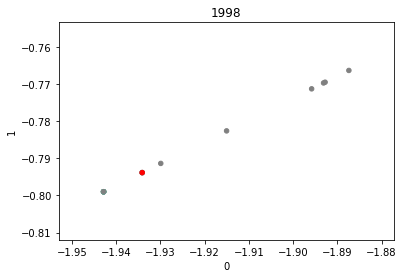

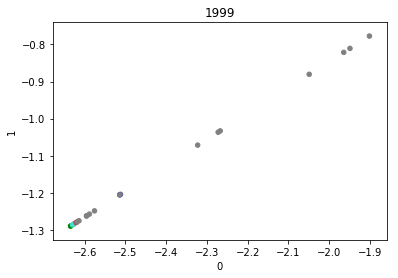

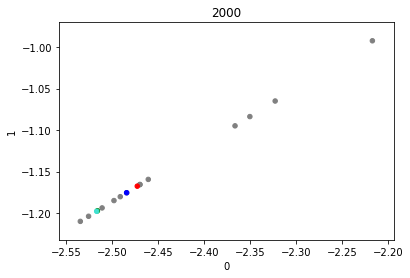

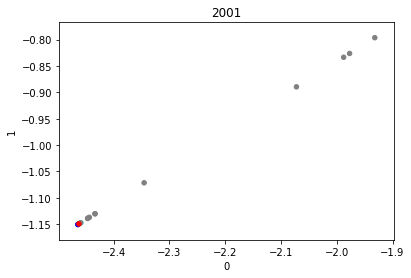

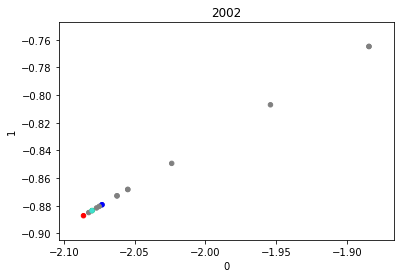

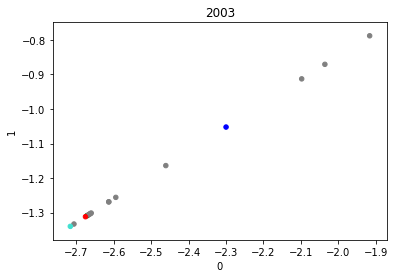

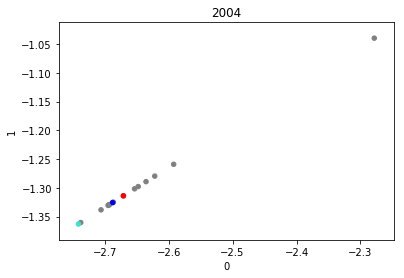

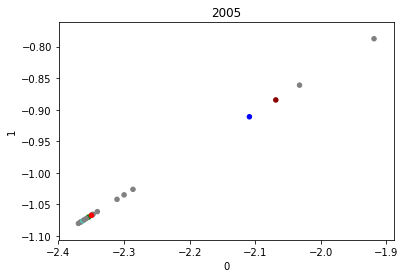

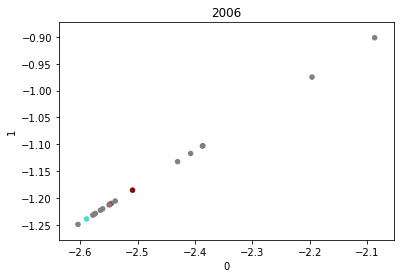

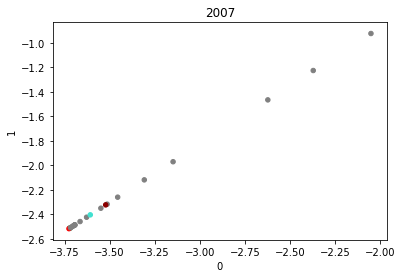

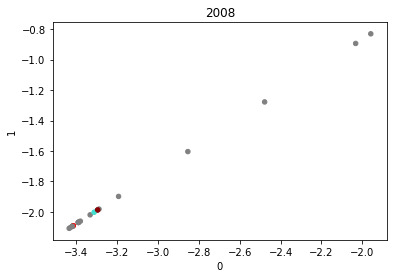

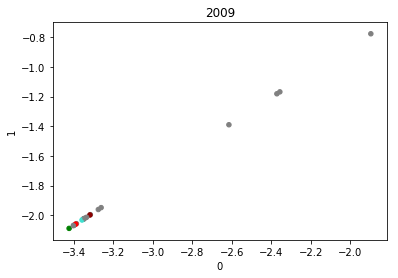

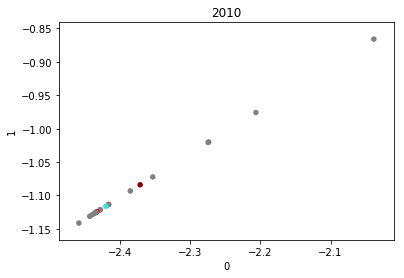

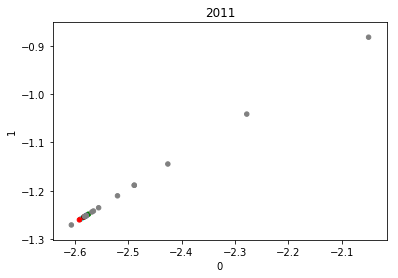

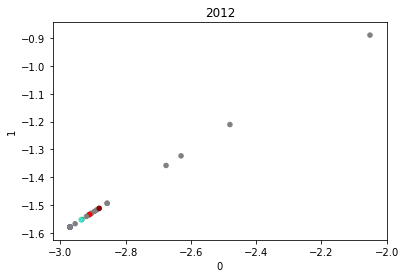

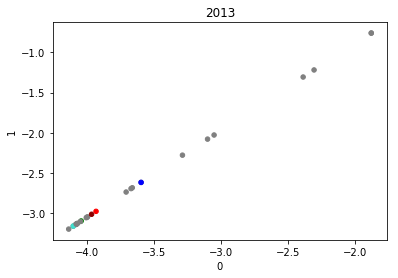

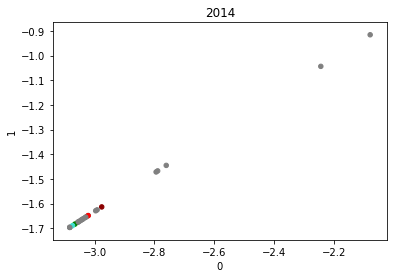

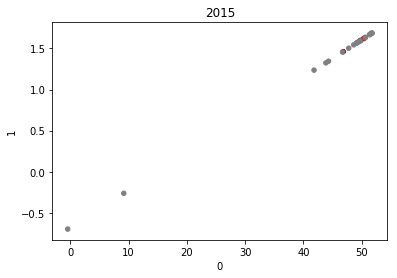

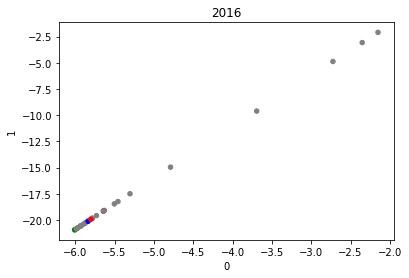

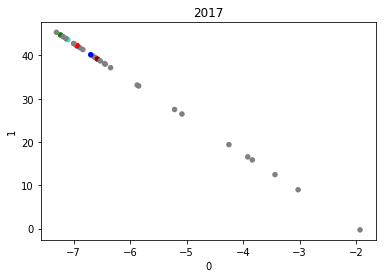

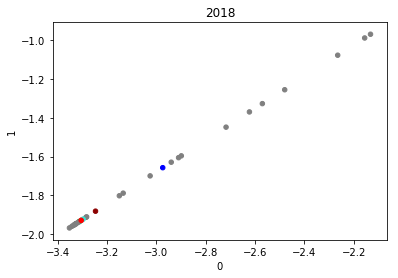

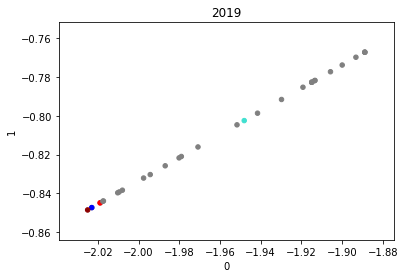

In [473]:
for year, group in df_X_r_2.groupby('year'):
    #plt.scatter(X_r.T[0], X_r.T[1], color=all_colors)
    cols = [def_col_df(party) for party in list(group['parties'])]
    group.plot.scatter(x=0, y=1, title=year, colors=cols)
    
    #all_colors = [ def_col(i, group[parties]) for i,col in enumerate(group[parties]) ]

In [226]:
df_X_r_2

,0,1,"(party, year)"
0,-3.137961e-07,-1.731301e+00,"(AVANTE, 2017)"
1,-2.171591e-05,9.681699e-04,"(AVANTE, 2018)"
2,8.520029e-09,1.510136e-07,"(AVANTE, 2019)"
3,-1.560319e-08,4.094139e-08,"(Apoio ao Governo, 2013)"
4,-7.899922e-09,-1.386616e-07,"(CIDADANIA, 2019)"
5,-1.237734e-06,1.266722e-04,"(DEM, 2007)"
6,4.573194e-06,-4.891605e-04,"(DEM, 2008)"
7,2.685577e-05,-9.992402e-04,"(DEM, 2009)"
8,3.832077e-09,5.511303e-07,"(DEM, 2010)"
9,-3.202757e-05,1.796037e-03,"(DEM, 2011)"


In [161]:
df3['data_votacao']

0      2006
1      2007
2      2008
3      2009
4      2010
5      2011
6      2012
7      2013
8      2015
9      2016
10     2017
11     2018
12     2019
13     2013
14     2014
15     2015
16     2016
17     2017
18     2018
19     2019
20     2019
21     2011
22     2012
23     2013
24     2014
25     2015
26     2016
27     2017
28     2018
29     2019
       ... 
484    2016
485    2017
486    2018
487    2019
488    2013
489    2017
490    2018
491    2019
492    2013
493    2014
494    2015
495    2016
496    2017
497    2018
498    2019
499    2005
500    2006
501    2007
502    2008
503    2009
504    2010
505    2011
506    2012
507    2013
508    2014
509    2015
510    2016
511    2017
512    2018
513    2019
Name: data_votacao, Length: 514, dtype: object